<div style="line-height:0.5">
<h1 style="color:#BF66F2 ">  Autoencoders in PyTorch 1 </h1>
<h4>  </h4>
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3> ConvTranspose2d + iter 
</span>
</div>
<br>
<div style="margin-top: -18px;\">
<div style="line-height:1.2\">
<span style="display: inline-block;\">
    <h3 style="color: red; display: inline;\">Notes:</h3> The "stl10_binary" archive that is downloaded weight 2.5 Gb.
</span>
</div>
</div> 

In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [2]:
### Define a transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
## Download the STL10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

100%|██████████| 2640397119/2640397119 [01:07<00:00, 39053404.66it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


In [6]:
class Autoencoder(nn.Module):
    """ An autoencoder for image compression and reconstruction.

    Encoder:
        - Conv2d: 3 input channels, 12 output channels, kernel_size=4, stride=2, padding=1
        - ReLU activation
        - Conv2d: 12 input channels, 24 output channels, kernel_size=4, stride=2, padding=1
        - ReLU activation
    
    Decoder:
        - ConvTranspose2d: 24 input channels, 12 output channels, kernel_size=4, stride=2, padding=1
        - ReLU activation
        - ConvTranspose2d: 12 input channels, 3 output channels, kernel_size=4, stride=2, padding=1
        - Sigmoid activation

        Methods:
            - forward(x): Perform a forward pass of the autoencoder.
        
        Args:
            - Input data x [Tensor]

        Returns:
            - Reconstructed input data x [Tensor]
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=4, stride=2, padding=1),  # [12, 48, 48]
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1),  # [24, 24, 24]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1),  # [12, 48, 48]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1),  # [3, 96, 96]
            nn.Sigmoid(),
        )

    def forward(self, x):
        """ Forward pass through the autoencoder. """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
""" Initialize the model, loss, and optimizer """
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
""" Train """
num_epochs = 5

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()


In [17]:
stl10_data = datasets.STL10(root='./data', split='test', download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(stl10_data, batch_size=1, shuffle=True)
test_loader

Files already downloaded and verified


In [11]:
# Load one sample image from STL10
data_iter = iter(test_loader)
img_tensor, _ = next(data_iter)      # not img_tensor, _ = data_iter.next()!

In [ ]:
""" Ensure no gradients are calculated """
with torch.no_grad():
    reconstruction = model(img_tensor)

In [12]:
## Reshape and permute to (96, 96, 3)
original_image = img_tensor.view(3, 96, 96).permute(1, 2, 0)
reconstruction_image = reconstruction.view(3, 96, 96).permute(1, 2, 0)

In [18]:
""" Clip or normalize values to be in [0, 1]
N.B.
It is necessary to avoid the warning:
"matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)"
"""
original_image = np.clip(original_image, 0, 1)
reconstruction_image = np.clip(reconstruction_image, 0, 1)

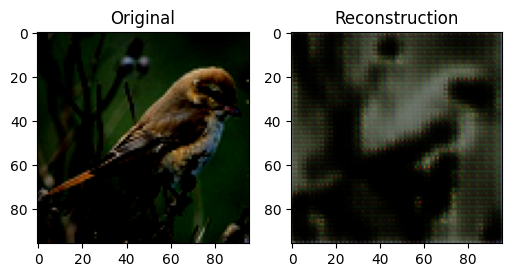

In [19]:
""" Display the original and reconstructed images. """
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(original_image.numpy())
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(reconstruction_image.numpy())
plt.title("Reconstruction")
plt.show()